In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
from __future__ import annotations

# debugging
from jax.tree_util import tree_map
import jax.tree_util

import argparse
import csv
import json
import os
import time
import matplotlib.pyplot as plt
from typing import Any, Tuple, Optional

plt.style.use('default')
from pathlib import Path
import sys
from dataclasses import dataclass, replace
sys.path.append(os.path.abspath('..'))

import jax
import jax.numpy as jnp
jnp.set_printoptions(precision=3, suppress=True)
import numpy as np
import optax

from floris import FlorisModel, TimeSeries

# from diffwake.diffwake_jax.model import load_input, create_state
# from diffwake.diffwake_jax import model
# from diffwake.diffwake_jax.layout_runner import make_layout_runner
# from diffwake.diffwake_jax.util import average_velocity_jax
# from diffwake.diffwake_jax.turbine.operation_models import power as power_fn
# from diffwake.diffwake_jax.simulator import simulate


# Wake model-agnostic edits to DiffWake
from diffwake.diffwake_jax.model_agnostic import load_input, create_state
from diffwake.diffwake_jax import model_agnostic
from diffwake.diffwake_jax.util_agnostic import average_velocity_jax, State, Result
from diffwake.diffwake_jax.turbine.operation_models import power as power_fn
from diffwake.diffwake_jax.sim_agnostic import simulate_simp, simulate


def absolute_percentage_difference(a, b):
    return jnp.abs((a - b) / b) * 100

# debugging helper
def check_types(x):
    print(f"Type: {type(x)}, value shape: {getattr(x, 'shape', 'N/A')}")
    return x


In [5]:
@dataclass
class DiffWakeConfig:
    data_dir: Path
    turbine_file: str
    generator_file: str
    farm_path: Path = None
    generator_path: Path = None

    def __post_init__(self):
        if self.farm_path is None:
            self.farm_path: Path = self.data_dir / self.turbine_file
        if self.generator_path is None:
            self.generator_path: Path = self.data_dir / self.generator_file


@dataclass
class DiffWakeParams:
    layout_x: Optional[jnp.ndarray] = None
    layout_y: Optional[jnp.ndarray] = None
    wind_speed: Optional[jnp.ndarray] = None
    wind_directions: Optional[jnp.ndarray] = None
    turbulence_intensities: Optional[jnp.ndarray] = None


class DiffWakeSimulation:
    def __init__(self,
                 config: DiffWakeConfig,
                 params: DiffWakeParams):
        self.config = config
        self.params = params

        self.state = None
        self.result = None
        self.__post_init__()

    def __post_init__(self) -> None:
        """
        Set-up simulation immediately after instantiation
        """
        if self.params.layout_x is None and self.params.layout_y is None:
            self.sim = load_input(
                farm_path=self.config.farm_path,
                generator_path=self.config.generator_path,
            ).set(
                wind_speeds=self.params.wind_speed,
                wind_directions=self.params.wind_directions,
                turbulence_intensities=self.params.turbulence_intensities
            )
        else:
            self.sim = load_input(
                farm_path=self.config.farm_path,
                generator_path=self.config.generator_path,
            ).set(
                layout_x=self.params.layout_x,
                layout_y=self.params.layout_y,
                wind_speeds=self.params.wind_speed,
                wind_directions=self.params.wind_directions,
                turbulence_intensities=self.params.turbulence_intensities
            )

    def update_params(self, **updates) -> None:
        self.params = replace(self.params, **updates)

    def run(self, scan: bool = False) -> Tuple[State, Result, float]:
        self.state = create_state(self.sim)
        # print("State structure")
        # print(jax.tree_util.tree_structure(self.state))
        # tree_map(check_types, self.state)
        time_start = time.time()
        if scan:
            # Use lax
            self.result = simulate(self.state)
        else:
            self.result = simulate_simp(self.state)
        time_end = time.time()


        return self.state, self.result, time_end - time_start

    def get_turbine_powers(self) -> jnp.ndarray:
        # Simulation must be run first
        if self.state is None or self.result is None:
            self.state, self.result = self.run()

        return power_fn(
            power_thrust_table=self.state.farm.power_thrust_table,
            velocities=self.result.u_sorted,
            air_density=self.state.flow.air_density,
            yaw_angles=self.state.farm.yaw_angles
        )

    def get_farm_power(self) -> float:
        return jnp.sum(self.get_turbine_powers()) / 1e6  # Convert watts to megawatts



In [6]:
data_dir = Path("data/horn")
cc_farm = "cc_hornsRev.yaml"
gch_farm = "gauss_hornsRev.yaml"
gen_file = "vestas_v802MW.yaml"

# Cartesian coordinates in metres
override_layout = False
layout_x = jnp.array([0.0, 500.0, 1000.0])
layout_y = jnp.array([0.0, 500.0, 1000.0])

# Inflow speed in m/s
wind_speed = jnp.array([13.5])
wind_dir = jnp.array([jnp.deg2rad(270.0)])
ti = jnp.array([0.06])

# Load configurations for each wake model
cc_config = DiffWakeConfig(data_dir, cc_farm, gen_file)
gch_config = DiffWakeConfig(data_dir, gch_farm, gen_file)


if override_layout == False:
    cc_params = DiffWakeParams(wind_speed=wind_speed,
                               wind_directions=wind_dir,
                               turbulence_intensities=ti)
    gch_params = DiffWakeParams(wind_speed=wind_speed,
                            wind_directions=wind_dir,
                            turbulence_intensities=ti)

else:
    cc_params = DiffWakeParams(layout_x=layout_x,
                               layout_y=layout_y,
                               wind_speed=wind_speed,
                               wind_directions=wind_dir,
                               turbulence_intensities=ti)
    gch_params = DiffWakeParams(layout_x=layout_x,
                               layout_y=layout_y,
                               wind_speed=wind_speed,
                               wind_directions=wind_dir,
                               turbulence_intensities=ti)


# Prepare simulations
cc_sim = DiffWakeSimulation(cc_config, cc_params)
cc_state, cc_result, cc_runtime = cc_sim.run()
cc_farm_power = cc_sim.get_farm_power()

gch_sim = DiffWakeSimulation(gch_config, gch_params)
gch_state, gch_result, gch_runtime = gch_sim.run()
gch_farm_power = gch_sim.get_farm_power()


### FLORIS simulation & DiffWake comparisons

In [11]:
# Horns Rev 1 simulation
# fmodel = FlorisModel(r"..\floris\examples\inputs\cc_vesta.yaml")
#
# fmodel_gch = FlorisModel(r"..\floris\examples\inputs\gauss_vesta.yaml")
#
# time_series = TimeSeries(
#     wind_directions=np.array([270.0]),
#     wind_speeds=np.array([13.5]),
#     turbulence_intensities=0.06,
# )
#
# fmodel.set(wind_data=time_series)
# cc_start_time = time.time()
# fmodel.run()
# cc_end_time = time.time()
#
#
# fmodel_gch.set(wind_data=time_series)
# gch_start_time = time.time()
# fmodel_gch.run()
# gch_end_time = time.time()
#
#
# gch_farm_power_floris = fmodel_gch.get_farm_power() / 1e6
# gch_turbine_powers_floris = fmodel_gch.get_turbine_powers()
# cc_farm_power_floris = fmodel.get_farm_power() / 1e6
# cc_turbine_powers_floris = fmodel.get_turbine_powers()


# Set printing precision

print("---------- DiffWake JAX Results ----------")
# print(f"Turbine powers with Gauss-Curl Hybrid (W): {gch_powers}")
print(f"Total farm power (MW): {gch_farm_power:.3f}")
# print(f"\nTurbine powers with Cumulative-Curl (W): {cc_powers}")
print(f"Total farm power (MW): {cc_farm_power:.3f}")

# print("\n---------- FLORIS Results ----------")
# # print(f"Turbine powers with Gauss-Curl Hybrid (W): {gch_turbine_powers_floris}")
# print(f"Total farm power (MW): {gch_farm_power_floris[0]:.3f}")
# # print(f"\nTurbine powers with Cumulative-Curl (W): {cc_turbine_powers_floris}")
# print(f"Total farm power (MW): {cc_farm_power_floris[0]:.3f}")
#
# print("\n---------- Differences ----------")
# print(f"Absolute farm power difference (GCH) = {absolute_percentage_difference(gch_farm_power_floris, gch_farm_power)[0]:.2f}%")
# print(f"Absolute farm power difference (CC) = {absolute_percentage_difference(cc_farm_power_floris, cc_farm_power)[0]:.2f}%")


---------- DiffWake JAX Results ----------
Total farm power (MW): 1.972
Total farm power (MW): 1.972


In [12]:
# print("------------ FLORIS runtimes ------------")
# print(f"Cumulative-Curl: {cc_end_time - cc_start_time:.4f}s")
# print(f"Gauss-Curl Hybrid: {gch_end_time - gch_start_time:.4f}s")

print("\n------------ DiffWake runtimes ------------")
print(f"Cumulative-Curl: {cc_runtime:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_runtime:.4f}s")


------------ DiffWake runtimes ------------
Cumulative-Curl: 4.6562s
Gauss-Curl Hybrid: 0.7230s


## jax.lax

Because the problem is relatively simple, we will now compare multi-direction and speed simulations to see if JAX provides an improvement.

DiffWake having a longer runtime is expected due to the relatively simple nature of the problem; the overheads are non-trivial.

There are options like lax.scan and lax.fori_loop but at the moment these are not so useful for simply running a simulation.
We will focus on writing optimisation loops, par_runner.py and use ideas from layout_runner.py.


In [16]:
# Run using lax_fori
cc_lax_start = time.time()
cc_sim.run(scan=True)
cc_lax_end = time.time()

gch_lax_start = time.time()
gch_sim.run(scan=True)
gch_lax_end = time.time()

cc_lax_runtime = cc_lax_end - cc_lax_start
gch_lax_runtime = gch_lax_end - gch_lax_start

print("\n------------ DiffWake runtimes (simple for loop) ------------")
print(f"Cumulative-Curl: {cc_runtime:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_runtime:.4f}s")

print("\n------------ DiffWake runtimes (lax) ------------")
print(f"Cumulative-Curl: {cc_lax_runtime:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_lax_runtime:.4f}s")

In [17]:
# Runtimes using lax
cc_lax = cc_lax_end - cc_lax_start
gch_lax = gch_lax_end - gch_lax_start
cc_lax_farm_power = cc_sim.get_farm_power() / 1e6
gch_lax_farm_power = gch_sim.get_farm_power() / 1e6

print("\n------------ DiffWake powers (jax.lax) ------------")
print(f"Total farm power (MW): {cc_lax_farm_power:.3f}")
print(f"Total farm power (MW): {gch_lax_farm_power:.3f}")
print("\n------------ DiffWake runtimes (jax.lax) ------------")
print(f"Cumulative-Curl: {cc_lax:.4f}s")
print(f"Gauss-Curl Hybrid: {gch_runtime:.4f}s")


------------ DiffWake powers (jax.lax) ------------
Total farm power (MW): 0.000

------------ DiffWake runtimes (jax.lax) ------------
Cumulative-Curl: 0.5586s


## FLORIS vs DiffWake runtime tests
Let's run through GCH and CC simulations using FLORIS and DiffWake to see the performance improvements.
The JAX-based implementations of GCH and CC should both yield linear runtimes whereas the FLORIS implementation of CC should lead to a runtime that varies quadratically with the number of turbines N (due to the nested loop). The FLORIS GCH implementation should be linear, since it only loops through the turbines once.
### Loop through 360 unique wind directions and 5 unique wind speeds using FLORIS and DiffWake

In [11]:
start = 50
stop = 200
N_turbines = [i for i in range(start, stop + 1)]
farm_powers = []
turbine_powers = []
# for i in range(len(N_turbines)):
#     cfg = cfg.set(
#         layout_x=jnp.arange(0.0, 500.0 * (N_turbines[i] - 1) + 1, 500.0),
#         layout_y=jnp.zeros(N_turbines[i]),
#         wind_speeds=wind_speed,
#         wind_directions=wind_dir,
#         turbulence_intensities=ti
#     )
#     state = create_state(cfg)
#     result = simulate(state)
#     # state_final = state.replace(flow=state.flow.replace(u=result.u_sorted))
#     powers = power_fn(
#     power_thrust_table=state.farm.power_thrust_table,
#     velocities=result.u_sorted,
#     air_density=state.flow.air_density,
#     yaw_angles=state.farm.yaw_angles_sorted
# )
#     farm_powers.append(jnp.sum(powers))
# %%
# Optimized Loop using JAX vmap
import time

# 1. Define configurations
N_max = max(N_turbines)
padded_layouts = []
for n in N_turbines:
    # Real turbines
    x_real = jnp.arange(0.0, 500.0 * (n - 1) + 1, 500.0)
    y_real = jnp.arange(0.0, 10 * (n - 1) + 1, 10.0)
    
    # Padding (place far away to avoid interaction)
    n_pad = N_max - n
    x_pad = jnp.ones(n_pad) * 1e6
    y_pad = jnp.ones(n_pad) * 1e6
    
    layout = jnp.column_stack([
        jnp.concatenate([x_real, x_pad]),
        jnp.concatenate([y_real, y_pad])
    ])
    padded_layouts.append(layout)

padded_layouts = jnp.stack(padded_layouts) # (Batch, N_max, 2)

# 2. Create a base state for N_max turbines
cfg_max = cfg.set(
    layout_x=jnp.zeros(N_max),
    layout_y=jnp.zeros(N_max),
    wind_speeds=wind_speed,
    wind_directions=wind_dir,
    turbulence_intensities=ti
)
state_max = create_state(cfg_max)

# 3. Create the optimized runner
# make_layout_runner returns a JIT-compiled function that takes layout (N_max, 2)
runner = make_layout_runner(state_max, grid_resolution=3)

# 4. Run using vmap
vmap_runner = jax.vmap(runner)

print("Starting JAX optimized run (including compilation)...")
start_time = time.time()
all_results = vmap_runner(padded_layouts)

# Trigger completion
all_results.u_sorted.block_until_ready()
end_time = time.time()
print(f"Optimized run time (with JIT): {end_time - start_time:.4f} s")

# 5. Extract farm powers
# We need to sum only the first 'n' turbine powers for each simulation in the batch.
# all_results.u_sorted has shape (Batch, B, N_max, Ny, Nz)

def get_total_power(u_sorted, n):
    p = power_fn(
        power_thrust_table=state_max.farm.power_thrust_table,
        velocities=u_sorted,
        air_density=state_max.flow.air_density,
        yaw_angles=state_max.farm.yaw_angles_sorted
    )
    # p shape: (B, N_max)
    # Mask out the padded turbines
    mask = jnp.arange(N_max) < n
    return jnp.sum(p * mask)

vmap_get_power = jax.vmap(get_total_power)
farm_powers_opt = vmap_get_power(all_results.u_sorted, jnp.array(N_turbines))

print(f"First few optimized farm powers: {farm_powers_opt[:5]}")
# %%
# JAX results
farm_powers = farm_powers_opt.tolist()




Starting JAX optimized run (including compilation)...
Optimized run time (with JIT): 17.6262 s
First few optimized farm powers: [1.6387794e+07 1.6669730e+07 1.6951398e+07 1.7232804e+07 1.7513956e+07]


In [13]:
from floris import FlorisModel, TimeSeries
import matplotlib.pyplot as plt
import numpy as np

# Load the default example floris object
fmodel = FlorisModel(r"E:\Aeronautics\fyp\floris\examples\inputs\cc_vesta.yaml")

# Define an inflow that
# keeps wind speed and TI constant while sweeping the wind directions
wind_directions = np.arange(0.0, 360.0, 1.0)

time_series = TimeSeries(
    wind_directions=wind_directions,
    wind_speeds=np.array([10.5]),
    turbulence_intensities=0.06,
)

N_turbines = [N_turbines]

floris_powers = []
turbine_powers = []

floris_time = time.time()
for i in range(len(N_turbines)):
    fmodel.reset_operation()
    fmodel.set(
        layout_x=np.arange(0.0, 500.0 * (N_turbines[i] - 1) + 1, 500.0),
        layout_y = np.arange(0.0, 10 * (N_turbines[i] - 1) + 1, 10.0),
        # layout_y=np.zeros(N_turbines[i]),
        wind_data=time_series,
    )
    fmodel.run()
    farm_power = fmodel.get_farm_power() / 1e6
    turbine_powers = fmodel.get_turbine_powers()
    floris_powers.append(farm_power[0])
end_floris_time = time.time()

floris_runtime = end_floris_time - floris_time
print(f"FLORIS runtime: {floris_runtime} seconds")

FLORIS runtime: 107.06288146972656 seconds


In [17]:
for i in range(len(floris_powers)):
    floris_powers[i] *= 1e6

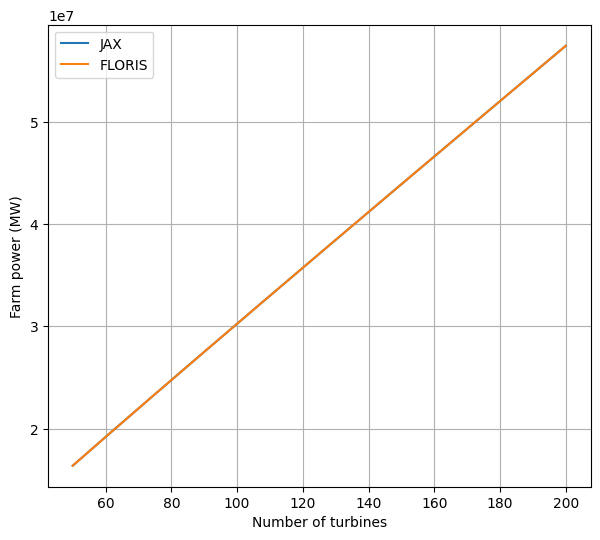

In [19]:
plt.style.use('default')
plt.figure(figsize=(7, 6))
plt.plot(N_turbines, farm_powers, label='JAX')
plt.plot(N_turbines, floris_powers, label='FLORIS')
plt.xlabel("Number of turbines")
plt.ylabel("Farm power (MW)")

plt.legend()
plt.grid()

In [20]:
diff = absolute_percentage_difference(jnp.array(farm_powers), jnp.array(floris_powers))
print(f"Absolute percentage difference: {diff}")

Absolute percentage difference: [0.00092751 0.00094182 0.00094387 0.00094006 0.00095923 0.00095532
 0.00097368 0.0009697  0.00097658 0.00098327 0.00098978 0.00098584
 0.00100227 0.00100827 0.00100426 0.0010198  0.00101577 0.00102131
 0.00102671 0.00103198 0.00103713 0.00105114 0.00104706 0.00104309
 0.00104788 0.00106113 0.00106561 0.00106999 0.00107428 0.00107848
 0.00108259 0.00107862 0.00108265 0.00109441 0.0010982  0.00110956
 0.00110554 0.0011166  0.00112002 0.00112338 0.0011194  0.0011299
 0.00112595 0.00112913 0.00113924 0.00114225 0.0011452  0.0011481
 0.00115095 0.00115375 0.00116311 0.00115921 0.00116836 0.00117092
 0.00117344 0.00117591 0.00117208 0.00118075 0.00118311 0.00119155
 0.00118772 0.00118998 0.0011922  0.00119438 0.00119654 0.0012103
 0.00121229 0.00121426 0.0012162  0.00121812 0.00122    0.00122186
 0.0012237  0.00123645 0.00122729 0.00122905 0.00124148 0.00124312
 0.00123418 0.00123585 0.00124789 0.00124944 0.00125098 0.00125249
 0.00125398 0.00125545 0.0012569 

Text(0.5, 1.0, 'Percentage difference between JAX & FLORIS farm powers')

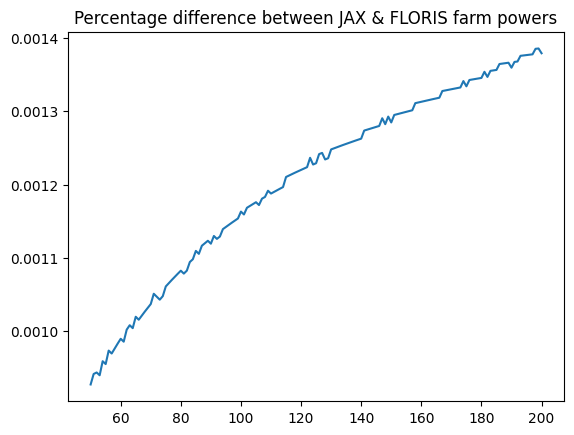

In [23]:
plt.plot(N_turbines, diff)
plt.title("Percentage difference between JAX & FLORIS farm powers")

In [27]:
print(f"FLORIS runtime (seconds): {floris_runtime:.4f}")
print(f"JAX runtime using vmap (seconds): {(end_time - start_time):.4f}")
print(f"Speed increase: {floris_runtime/(end_time - start_time):.4f}")

FLORIS runtime (seconds): 107.0629
JAX runtime using vmap (seconds): 17.6262
Speed increase: 6.0741


In [2]:
# Test how to check for class objects
class Drink:
    def __init__(self, drink: str = 'Water'):
        self.drink = drink

    def get_drink(self):
        return self.drink

In [4]:
myDrink = Drink("orange juice")
print(f"{myDrink} is of type {type(myDrink)}")

<__main__.Drink object at 0x0000022C091EEC90> is of type <class '__main__.Drink'>


In [5]:
myDrink